In [1]:
is_skip = True

# Data params
batch_size = 128
min_encode_len = 30
max_encode_len = 30
pred_len = 7
padding_val = 0

valid_start_date = "2020-01-01"

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0
num_layers = 8

# Import

In [2]:
import joblib
import copy
import time

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

device = torch.device("cuda:0")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [4]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)

In [5]:
def preprocess(data, df_meta, is_train=True):
    data = data.copy()
    static_cols = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

    # Make sales
    data = data.groupby(["t_dat", "article_id", *static_cols], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(1e-5) # Make sure the original data has no zero
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")

    # Diff
    data["shift"] = data["sales"].shift(1)
    data["diff"] = data["sales"] - data["shift"]

    # Accumulate sales
    data = data.sort_values(["article_id", "t_dat"]).reset_index(drop=True)
    data["accm"] = data.groupby("article_id")["sales"].cumsum()

    # Scaler
    if is_train:
        scaler_li = {}
        for col in ["sales", "diff", "accm"]:
            scaler =  MinMaxScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_minmax"] = scaler

            scaler =  StandardScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_standard"] = scaler
            
            scaler =  RobustScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_robust"] = scaler
            
            scaler = LogScaler()
            scaler.fit(data[f"{col}"].values.reshape(-1,1))
            scaler_li[f"{col}_log"] = scaler
    else: scaler_li = None

    # Temporal information
    temporal_cols = ["price", "day_sin", "day_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    data["day"] = data["t_dat"].dt.day
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month

    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    append_cyclic("day", 365)
    append_cyclic("dow", 7)
    append_cyclic("month", 12)
    
    # Data to list
    data = data.groupby("article_id", as_index=False)[["sales", "diff", "accm"] + temporal_cols].agg(list)

    # Size restriction
    data["size"] = data["sales"].str.len()
    # data = data[data["size"] >= min_size]

    return data, static_cols, temporal_cols, scaler_li

if not is_skip:
    df_prep = df_raw[df_raw["index_name"] == "Ladieswear"]
    # df_prep = df_raw.copy()

    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train, static_cols, temporal_cols, scaler_li = preprocess(df_train, df_meta)
    df_train.to_parquet("df_train.pq")
    joblib.dump(static_cols, "static_cols.pkl")
    joblib.dump(temporal_cols, "temporal_cols.pkl")
    joblib.dump(scaler_li, "scaler_li.pkl")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid, _, _, _ = preprocess(df_valid, df_meta)
    df_valid.to_parquet("df_valid.pq")

### Dataset

decoder_input: torch.Size([128, 30, 1])
input_padding_mask: torch.Size([128, 30])
y: torch.Size([128, 7])


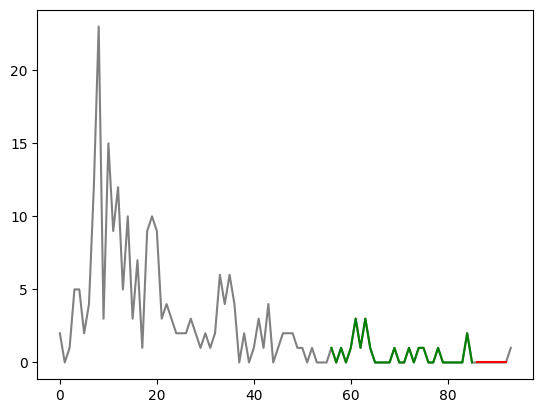

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
static_cols = joblib.load("static_cols.pkl")
temporal_cols = joblib.load("temporal_cols.pkl")
scaler_li = joblib.load("scaler_li.pkl")
target_col = "sales"
scaler_name = "standard"
scaler_name = f"{target_col}_{scaler_name}"

df_train = df_train[df_train["size"] >= min_encode_len + pred_len]
df_valid = df_valid[df_valid["size"] >= min_encode_len + pred_len]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target_col, min_encode_len, max_encode_len, pred_len):
        self.min_encode_len, self.max_encode_len, self.pred_len = min_encode_len, max_encode_len, pred_len

        self.target = data[target_col].values
    
    def __len__(self):
        return self.target.shape[0]
    
    def get_output_idx(self, seq_len):
        idx_seq = np.arange(0, seq_len)
        filtered_idx_seq = np.where(
                            (idx_seq >= self.min_encode_len)
                            &(idx_seq <= seq_len - self.pred_len)
                            )[0]
        try:
            output_start_idx = np.random.randint(filtered_idx_seq[0], filtered_idx_seq[-1]+1)
        except:
            1==1
            raise
        output_idx = idx_seq[output_start_idx : output_start_idx+self.pred_len]
        return output_idx
    
    def get_input_idx(self, output_start_idx, seq_len):
        idx_seq = np.arange(0, seq_len)
        input_len = np.random.randint(self.min_encode_len, min(output_start_idx, self.max_encode_len)+1)
        input_start_idx = output_start_idx - input_len
        input_idx = idx_seq[input_start_idx:input_start_idx+input_len]

        return input_idx

    def __getitem__(self, idx):
        target = self.target[idx]

        # Input output split
        output_idx = self.get_output_idx(target.shape[0])
        input_idx = self.get_input_idx(output_idx[0], target.shape[0])
        
        decoder_input = target[input_idx]
        y = target[output_idx]

        return {"decoder_input": decoder_input,
                "y": y,
                "target_original": target,
                "decoder_input_idx": input_idx,
                "y_idx": output_idx
                }

def collate_fn(batch_li, scaler):
    # Model input data
    decoder_input_raw = [torch.Tensor(batch["decoder_input"]) for batch in batch_li]
    y_raw = torch.Tensor(np.array([batch["y"] for batch in batch_li]))

    # Analysis data
    target_original = [batch["target_original"] for batch in batch_li]
    decoder_input_idx = [batch["decoder_input_idx"] for batch in batch_li]
    y_idx = [batch["y_idx"] for batch in batch_li] # For analysis

    # Padding
    input_padding_mask = torch.nn.utils.rnn.pad_sequence(decoder_input_raw, padding_value=-0, batch_first=True) # Since original data has no zero, it is okay to pad with 0
    input_padding_mask = torch.where(input_padding_mask==-0, 0, 1) # If valid, then 1
    
    # Scaling
    # There is going to be both valid zeros and padding zeros
    # but it is okay since packing will deal with it with the length of each row
    decoder_input = torch.nn.utils.rnn.pad_sequence(decoder_input_raw, padding_value=-0, batch_first=True) # Since original data has no zero, it is okay to pad with 0
    decoder_input = torch.Tensor(scaler.transform(decoder_input.reshape(-1,1))).reshape(decoder_input.shape)
    y = torch.Tensor(scaler.transform(y_raw.reshape(-1,1))).reshape(y_raw.shape)

    # Packing
    arr_len = [len(row) for row in decoder_input_raw]
    decoder_input = torch.nn.utils.rnn.pack_padded_sequence(decoder_input.unsqueeze(-1), arr_len, batch_first=True, enforce_sorted=False)

    return {
            "decoder_input": decoder_input,
            "input_padding_mask": input_padding_mask,
            "y": y,
            "target_original": target_original,
            "y_original": y,
            "decoder_input_idx": decoder_input_idx,
            "y_idx": y_idx
            }

train_dataset = Dataset(df_train, target_col, min_encode_len, max_encode_len, pred_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, scaler_li[scaler_name]))

valid = Dataset(df_valid, target_col, min_encode_len, max_encode_len, pred_len)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, scaler_li[scaler_name]))

def plot_sample(total_seq, input_seq, input_idx, pred_seq, pred_idx, scaler, sample_idx=-1):
    # Unpack and inverse transform
    input_idx = input_idx[sample_idx]
    input_seq = torch.nn.utils.rnn.pad_packed_sequence(input_seq, batch_first=True)[0][sample_idx][:len(input_idx)]
    input_seq = scaler.inverse_transform(input_seq.reshape(-1,1)).reshape(input_seq.shape).squeeze(-1)
    
    pred_idx = pred_idx[sample_idx]
    pred_seq = pred_seq[sample_idx][:len(pred_idx)]
    pred_seq = scaler.inverse_transform(pred_seq.reshape(-1,1)).reshape(pred_seq.shape)

    # Make dataframe
    df_total_seq = pd.DataFrame({"total_seq":total_seq[sample_idx]}).reset_index()
    df_input_seq = pd.DataFrame({"input_seq":input_seq, "index":input_idx})
    df_pred_seq = pd.DataFrame({"pred_seq":pred_seq, "index":pred_idx})
    df = df_total_seq.merge(df_input_seq, on="index", how="outer").merge(df_pred_seq, on="index", how="outer")

    # Plot
    plt.plot(df["total_seq"], color="gray")
    plt.plot(df["input_seq"], color="green")
    plt.plot(df["pred_seq"], color="red")

for data in train_dataloader:
    print("decoder_input:", torch.nn.utils.rnn.pad_packed_sequence(data["decoder_input"], batch_first=True)[0].shape)
    print("input_padding_mask:", data["input_padding_mask"].shape)
    print("y:", data["y"].shape)
    break

plot_sample(
    total_seq = data["target_original"],
    input_seq = data["decoder_input"],
    input_idx = data["decoder_input_idx"],
    pred_seq = data["y"],
    pred_idx = data["y_idx"],
    scaler = scaler_li[scaler_name]
    )

# Architecture

In [7]:
from torch.nn import functional as F

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask, src_key_padding_mask, is_causal=False):
       ####################################################################################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(src_mask),
            other_name="src_mask",
            target_type=src.dtype
        )

        src_mask = F._canonical_mask(
            mask=src_mask,
            mask_name="src_mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
        why_not_sparsity_fast_path = ''
        if not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif self.training:
            why_not_sparsity_fast_path = "training is enabled"
        elif not self.self_attn.batch_first :
            why_not_sparsity_fast_path = "self_attn.batch_first was not True"
        elif not self.self_attn._qkv_same_embed_dim :
            why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
        elif not self.activation_relu_or_gelu:
            why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
        elif not (self.norm1.eps == self.norm2.eps):
            why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
        elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
            why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
        elif self.self_attn.num_heads % 2 == 1:
            why_not_sparsity_fast_path = "num_head is odd"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"
        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )

            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif not all((x.device.type in _supported_device_type) for x in tensor_args):
                why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
                                              f"{_supported_device_type}")
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if not why_not_sparsity_fast_path:
                merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    self.norm_first,
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    merged_mask,
                    mask_type,
                )
       ####################################################################################################################################################################################
        x = src
        if self.norm_first: raise
        else:
            self_attn, attn_weight = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
            x = self.norm1(x + self_attn)
            x = self.norm2(x + self._ff_block(x))

        return x, attn_weight
    
    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, is_causal=None):
       ########################################################################################################################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ########################################################################################################################################################################################################################
        for mod in self.layers:
            output, attn_weight = mod(output, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        self.lstm = torch.nn.LSTM(1, d_model, batch_first=True, bidirectional=True)
        self.lstm_linear = torch.nn.Linear(d_model*2, d_model)
        self.encoder = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)
        self.linear = torch.nn.Linear(d_model, pred_len)
        self.layer_norm = torch.nn.LayerNorm(d_model)

    def forward(self, decoder_input, input_padding_mask):
        lstm_output, _ = self.lstm(decoder_input)
        lstm_output, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first=True)
        lstm_output = self.lstm_linear(lstm_output)

        # Encoder
        src_key_padding_mask = torch.where(input_padding_mask==1, 0, -torch.inf)
        encoder_output, attn_weight = self.encoder(lstm_output, src_key_padding_mask =src_key_padding_mask)
        
        output = self.layer_norm(encoder_output[:, 0, :])
        output = self.linear(output).unsqueeze(-1)
        return output, attn_weight

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["decoder_input"].to(device),
        data["input_padding_mask"].to(device),
        show_parent_layers=True, print_summary=True)

-------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                                                      Output Shape         Param #     Tr. Param #
     Transformer             LSTM-1     [3840, 256], [30], [128], [128], [2, 128, 128], [2, 128, 128]         134,144         134,144
     Transformer           Linear-2                                                    [128, 30, 128]          32,896          32,896
     Transformer          Encoder-3                                     [128, 30, 128], [128, 30, 30]       1,059,840       1,059,840
     Transformer        LayerNorm-4                                                        [128, 128]             256             256
     Transformer           Linear-5                                                          [128, 7]             903             903
Total params: 1,228,039
Trainable params: 1,228,039
Non-traina

'-------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                                                      Output Shape         Param #     Tr. Param #\n=====================================================================================================================================\n     Transformer             LSTM-1     [3840, 256], [30], [128], [128], [2, 128, 128], [2, 128, 128]         134,144         134,144\n     Transformer           Linear-2                                                    [128, 30, 128]          32,896          32,896\n     Transformer          Encoder-3                                     [128, 30, 128], [128, 30, 30]       1,059,840       1,059,840\n     Transformer        LayerNorm-4                                                        [128, 128]             256             256\n     Transformer           Linear-5                   

# Train

epoch 4 - loss: 0.5780329728871584


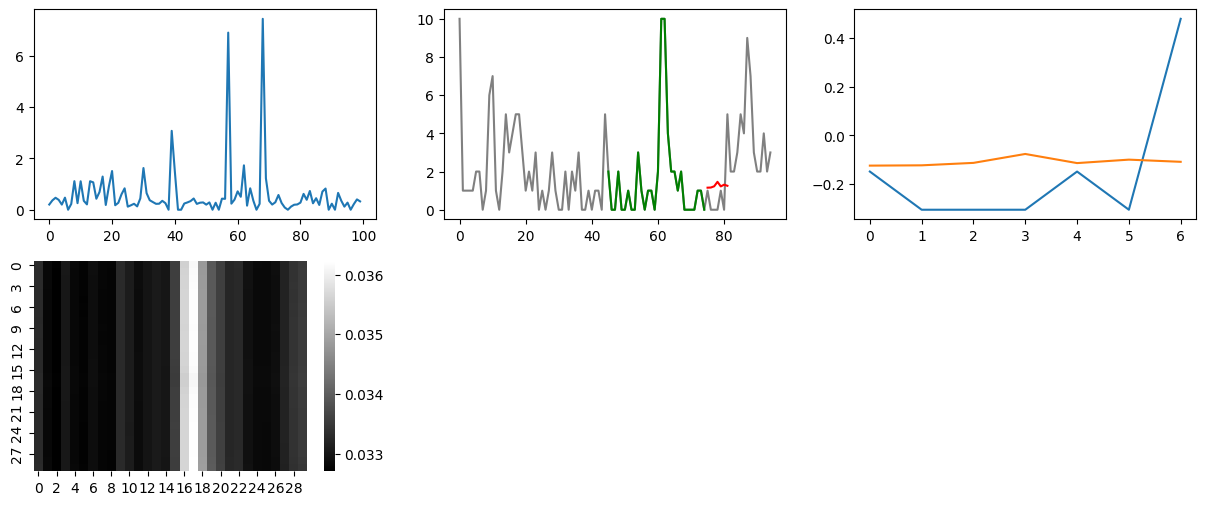

100%|██████████| 139/139 [00:04<00:00, 30.36it/s]


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# mse_loss = torch.nn.MSELoss(reduction="none")
mse_loss = torch.nn.MSELoss()

batch_size = 16

def mse_loss_fn(pred, y, y_original):
    mask = torch.where(y_original<5, 0, 1).type(torch.FloatTensor).to(device).unsqueeze(-1)
    loss = mse_loss(pred, y)
    masked_loss = loss * mask
    1==1
    if masked_loss.sum() == 0 and mask.sum() == 0:
        return loss*0
    else :
        return masked_loss.sum() / mask.sum()

def report(data, pred, attn_weight, window, loss_li, is_plot=True):
    sample_idx = -1
    clear_output(wait=True)
    print(f"epoch {e} - loss: {np.mean(loss_li[-window:])}")
    
    if is_plot:
        plt.figure(figsize=(15,6))
        nrows, ncols = 2, 3

       # Plot loss
        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li[-window:])
        
       # Plot sample (full size)
        plt.subplot(nrows, ncols, 2)
        plot_sample(
            total_seq = data["target_original"],
            input_seq = data["decoder_input"],
            input_idx = data["decoder_input_idx"],
            pred_seq = pred.detach().cpu().squeeze(-1),
            pred_idx = data["y_idx"],
            scaler = scaler_li[scaler_name],
            sample_idx=sample_idx
            )
       
       # Plot sample (in detail)
        plt.subplot(nrows, ncols, 3)
        plt.plot(data["y"][sample_idx])
        plt.plot(pred[sample_idx].squeeze(-1).detach().cpu().numpy())
    
       # Plot attention
        plt.subplot(nrows, ncols, 4)
        attn_weight = attn_weight[sample_idx].detach().cpu()
        sns.heatmap(attn_weight, cmap="gray")

        plt.show()

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, attn_weight = model(
                    data["decoder_input"].to(device),
                    data["input_padding_mask"].to(device),
                    )
        # loss = mse_loss(pred, data["y"].unsqueeze(-1).to(device))
        loss = mse_loss_fn(pred, data["y"].unsqueeze(-1).to(device), data["y_original"].unsqueeze(-1))
        loss_li.append(loss.item())
        loss.backward()
        optimizer.step()

        if n % 10 == 0:
            report(data, pred, attn_weight, window, loss_li, is_plot=True)
    return model, np.mean(loss_li[-window:])

def valid(model, loss):
    pbar = tqdm(valid_dataloader)

    for n, data in enumerate(pbar):
        model.eval()
        with torch.no_grad():
            pred = model(
                        data["decoder_input"].to(device),
                        data["input_padding_mask"].to(device),
                        )

            clear_output(wait=True)
            print(f"scaler: {scaler_name}, loss: {loss}")
            plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            plot_sample(
                total_seq = data["target_original"],
                input_seq = data["decoder_input"],
                input_idx = data["decoder_input_idx"],
                pred_seq = pred.detach().cpu().squeeze(-1),
                pred_idx = data["y_idx"],
                scaler = scaler_li[scaler_name]
                )

            plt.subplot(1,2,2)
            plt.plot(data["y"][-1])
            plt.plot(pred[-1].squeeze(-1).detach().cpu().numpy())
            plt.show()
            if input() == "break":
                break

epoch = 5
for e in range(epoch):
    model, loss = train(e)
    # valid(model, loss)
    plt.show()